In [ ]:
# LSTM 有两层 LSTM 的结构

In [18]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
import random
import matplotlib.pyplot as plt

# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date'], axis=1)
# print(dataset.columns)
# print(dataset.tail())
dataset = dataset.fillna(0)

# print(dataset.shape)
# print(dataset.tail())


# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
SEQ_LENGTH = 60
BATCH_SIZE = 440                                                        # 注意：BATCH_SIZE是要能够整除(total_seq_count-1)的
TEST_BATCH_COUNT = 1
Y_SEQ_LEN = 1                                                         # 要用2个y来表示预测的第一天和预测的第二天，对应 "future" 和 "future2",每个y都是1-D的，y的seq_len是2
Y_DIM = 1
X_DIM = dataset.shape[1]-Y_SEQ_LEN                                    # 表示输入的sequence里每个element有122维度，也是encoder的input_dim

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                   # 数据一共是 seq_count x seq_len x (x_in_dim+Y_SEQ_LEN) 

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))
print("batch size: {}".format(BATCH_SIZE))


train = rolling_data[:-1].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 tain_batch_count x BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-BATCH_SIZE:].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)  # 把数据转成 test_batch_count x BATCH_SIZE x seq_len x in_dim 格式

train = torch.tensor(train)
test  = torch.tensor(test)

# train = rolling_data[:train_batch_count, :, :, :]
# test  = rolling_data[train_batch_count:, :, :, :]

train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]

train_y = train_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
test_y  =  test_y.permute(0, 1, 3, 2)                                    # conver from [test_batch_count, batch_size, seq_length, y_seq_len]  to  [test_batch_count, batch_size, y_seq_len, 1-dim]

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train.shape[0]))
print("test_batch_count:  {}".format(test.shape[0]))

rolling_data shape: (441, 60, 129)
seq count: 441
seq length: 60
batch size: 440
train_x: torch.Size([1, 440, 60, 128])
train_y: torch.Size([1, 440, 1, 1])
test_x:  torch.Size([1, 440, 60, 128])
test_y:  torch.Size([1, 440, 1, 1])
train_batch_count: 1
test_batch_count:  1


In [19]:
# 定义 LSTM 模型
np.random.seed(1027)
torch.manual_seed(1027)
torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

TIME_STEP = SEQ_LENGTH                                        # 一般这个单独设定，这里为了简单，还是直接就等于seq_len的方便。其实也就是等于最长的那个sequence length
HIDDEN_SIZE = 768
NUM_LAYERS = 2


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=int(hidden_layer_size/2), num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=int(hidden_layer_size/2), hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.linear_1 = nn.Linear(hidden_layer_size, int(hidden_layer_size/4))
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(hidden_layer_size, output_size)

        self.h10 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_layer_size/2)).double().to(device)
        self.c10 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_layer_size/2)).double().to(device)
        self.h20 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size).double().to(device)
        self.c20 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size).double().to(device)
        
        self.init_weights2()

    def init_weights1(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def init_weights2(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
                
    def init_weights3(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def forward(self, x):

        # layer 1
        # x = self.linear_1(x)
        x = self.dropout(x)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch        
        # LSTM layer
        # lstm_out, (h_n, c_n) = self.lstm(x, (self.h0.detach(), self.c0.detach()))
        
        lstm1_out, (h1_n, c1_n) = self.lstm1(x, (self.h10, self.c10))
        
        lstm1_out = self.dropout(lstm1_out)
        
        lstm_out, (h_n, c_n) = self.lstm2(lstm1_out, (self.h20, self.c20))

        # lstm_out = self.dropout(lstm_out)
        
        predictions = self.linear_2(lstm_out)
        return predictions


In [20]:
# 定义 LSTM 模型
np.random.seed(1027)
torch.manual_seed(1027)
torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

TIME_STEP = SEQ_LENGTH                                        # 一般这个单独设定，这里为了简单，还是直接就等于seq_len的方便。其实也就是等于最长的那个sequence length
HIDDEN_SIZE = 768
NUM_LAYERS = 2


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=int(hidden_layer_size/2), num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=int(hidden_layer_size/2), hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.linear_1 = nn.Linear(hidden_layer_size, int(hidden_layer_size/4))
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(hidden_layer_size, output_size)

        self.h10 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_layer_size/2)).double().to(device)
        self.c10 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_layer_size/2)).double().to(device)
        self.h20 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size).double().to(device)
        self.c20 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size).double().to(device)
        
        self.init_weights2()

    def init_weights1(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def init_weights2(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
                
    def init_weights3(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def forward(self, x):

        # layer 1
        # x = self.linear_1(x)
        x = self.dropout(x)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch        
        # LSTM layer
        # lstm_out, (h_n, c_n) = self.lstm(x, (self.h0.detach(), self.c0.detach()))
        
        lstm1_out, (h1_n, c1_n) = self.lstm1(x, (self.h10, self.c10))
        
        lstm1_out = self.dropout(lstm1_out)
        
        lstm_out, (h_n, c_n) = self.lstm2(lstm1_out, (self.h20, self.c20))

        # lstm_out = self.dropout(lstm_out)
        
        predictions = self.linear_2(lstm_out)
        return predictions


In [21]:
# 实例化 LSTM 模型
model = LSTMModel(input_size=X_DIM, hidden_layer_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1)
model = model.double().to(device)
LR = 1e-4
loss_func = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)

0 of 100 epoch loss: 0.0101 with lr: 0.0001
1 of 100 epoch loss: 0.0633 with lr: 0.0001
2 of 100 epoch loss: 0.0111 with lr: 0.0001
3 of 100 epoch loss: 0.0198 with lr: 0.0001
4 of 100 epoch loss: 0.0300 with lr: 0.0001
5 of 100 epoch loss: 0.0211 with lr: 0.0001
6 of 100 epoch loss: 0.0104 with lr: 0.0001
7 of 100 epoch loss: 0.0083 with lr: 0.0001
8 of 100 epoch loss: 0.0127 with lr: 0.0001
9 of 100 epoch loss: 0.0154 with lr: 0.0001
10 of 100 epoch loss: 0.0142 with lr: 0.0001
11 of 100 epoch loss: 0.0105 with lr: 0.0001
12 of 100 epoch loss: 0.0082 with lr: 0.0001
13 of 100 epoch loss: 0.0084 with lr: 0.0001
14 of 100 epoch loss: 0.0098 with lr: 0.0001
15 of 100 epoch loss: 0.0108 with lr: 0.0001
16 of 100 epoch loss: 0.0104 with lr: 0.0001
17 of 100 epoch loss: 0.0094 with lr: 0.0001
18 of 100 epoch loss: 0.0081 with lr: 0.0001
19 of 100 epoch loss: 0.0078 with lr: 0.0001
20 of 100 epoch loss: 0.0080 with lr: 0.0001
21 of 100 epoch loss: 0.0085 with lr: 0.0001
22 of 100 epoch loss

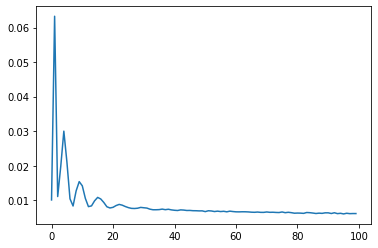

In [22]:
# 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model.train()
epoches = 100
epoch_loss = 0
epoch_loss_list = []
train_batch_count = train_x.shape[0]

for epoch in range(epoches):
    for step in range(train_batch_count):
        pred = model(train_x[step])
        loss = loss_func(pred[:,-1], train_y[step][:,-1])                # Compare the all sequences' last element in one batch
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        
        epoch_loss += loss.data.cpu()
        
    if epoch_loss.item() < 1e-4:
        print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch+1, epoches, loss.item()))
        print("The loss value is reached")
        break

    print("{} of {} epoch loss: {:.4f} with lr: {}".format(epoch, epoches, epoch_loss.item(), optimizer.state_dict()['param_groups'][0]['lr']))
    epoch_loss_list.append(epoch_loss)
    epoch_loss = 0
    
    if (epoch+1) % 50 ==0:
        scheduler.step()
    # print("learning rate: {}".format(optimizer.state_dict()['param_groups'][0]['lr']))
    # for p in optimizer.param_groups:
    #     p['lr'] *= 0.99
    
plt.plot(epoch_loss_list)
plt.show()    

In [23]:
# 保存模型
torch.save(model, 'e:\\Model_LSTM2.pkl')

In [24]:
# 加载模型
model = torch.load('e:\\Model_LSTM2.pkl')

torch.Size([440, 60, 1])
torch.Size([1])
torch.Size([1])
torch.Size([440, 1, 1])
Prediction Loss average:0.002396
Prediction: -0.05
Actual:     0.00


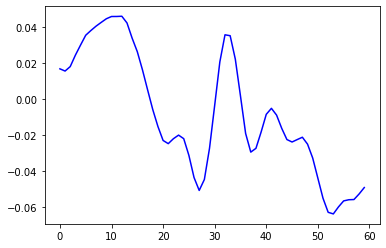

In [31]:
# 用模型预测数据
model.eval()
test_loss = 0
test_batch_count = test_x.shape[0]

for step in range(test_batch_count):
    pred = model(test_x[step])

    loss = loss_func(pred[-1,-1], test_y[step][-1,-1])                # Compare the all sequences' last element in one batch
    
    test_loss += loss.cpu()
    
print("Prediction Loss average:{:.6f}".format(test_loss.data/(step+1)))
print("Prediction: {:.2f}".format(float(pred[-1,-1].data)))
print("Actual:     {:.2f}".format(float(test_y[step][-1,-1].data)))

actual_line = test_y[step][-1].cpu().detach().flatten().numpy()        # Only plot the last sequence of test batch
pred_line   = pred[-1].cpu().detach().flatten().numpy()                # Only plot the last sequence of test batch
plt.plot(actual_line, 'r--')
plt.plot(pred_line, 'b-')
plt.show()
